In [1]:
import keras
keras.__version__

/home/leechan/anaconda3/envs/DLCNN/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.6'

In [2]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base'
train_dir = os.path.join(base_dir, 'train_dir')
validation_dir = os.path.join(base_dir, 'validation_dir')

test_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base/test_dir'

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 15

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

def extract_features_test(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None)
    i = 0
    for inputs_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        i += 1
        if i * batch_size >= sample_count:
            break
            
    return features

test_features = extract_features_test(test_dir, 12500)
train_features, train_labels = extract_features(train_dir, 20000)
validation_features, validation_labels = extract_features(validation_dir, 5000)

Found 12500 images belonging to 1 classes.
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [6]:
train_features = np.reshape(train_features, (20000, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (5000, 7 * 7 * 512))
test_features = np.reshape(test_features, (12500, 7 * 7 * 512))

In [16]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [17]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=120,
                    validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 2s 101us/step - loss: 0.3628 - acc: 0.8379 - val_loss: 0.2461 - val_acc: 0.9012
Epoch 2/30
20000/20000 [==============================] - 2s 98us/step - loss: 0.2290 - acc: 0.9052 - val_loss: 0.2022 - val_acc: 0.9194
Epoch 3/30
20000/20000 [==============================] - 2s 94us/step - loss: 0.1928 - acc: 0.9224 - val_loss: 0.1970 - val_acc: 0.9190
Epoch 4/30
20000/20000 [==============================] - 2s 97us/step - loss: 0.1742 - acc: 0.9321 - val_loss: 0.1814 - val_acc: 0.9278
Epoch 5/30
20000/20000 [==============================] - 2s 97us/step - loss: 0.1584 - acc: 0.9372 - val_loss: 0.1721 - val_acc: 0.9326
Epoch 6/30
20000/20000 [==============================] - 2s 97us/step - loss: 0.1449 - acc: 0.9440 - val_loss: 0.1731 - val_acc: 0.9302
Epoch 7/30
20000/20000 [==============================] - 2s 94us/step - loss: 0.1369 - acc: 0.9472 - val_loss: 0.1679 - val_acc

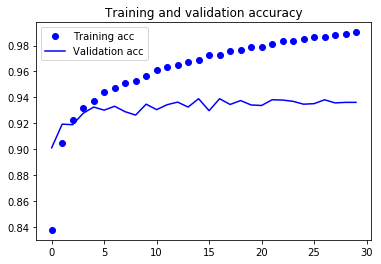

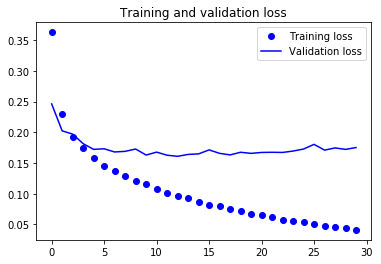

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [36]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4


In [37]:
conv_base.trainable = False

In [38]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [39]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=50,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=50,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=400,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=100,
      verbose=2)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/30
 - 196s - loss: 0.3917 - acc: 0.8225 - val_loss: 0.2152 - val_acc: 0.9122
Epoch 2/30
 - 191s - loss: 0.2925 - acc: 0.8739 - val_loss: 0.1888 - val_acc: 0.9220
Epoch 3/30
 - 191s - loss: 0.2699 - acc: 0.8817 - val_loss: 0.1838 - val_acc: 0.9260
Epoch 4/30
 - 191s - loss: 0.2569 - acc: 0.8896 - val_loss: 0.1875 - val_acc: 0.9266
Epoch 5/30
 - 191s - loss: 0.2482 - acc: 0.8917 - val_loss: 0.2035 - val_acc: 0.9234
Epoch 6/30
 - 191s - loss: 0.2442 - acc: 0.8976 - val_loss: 0.2078 - val_acc: 0.9178
Epoch 7/30
 - 192s - loss: 0.2388 - acc: 0.8994 - val_loss: 0.1746 - val_acc: 0.9332
Epoch 8/30
 - 192s - loss: 0.2338 - acc: 0.9016 - val_loss: 0.1682 - val_acc: 0.9322
Epoch 9/30
 - 192s - loss: 0.2308 - acc: 0.9007 - val_loss: 0.1737 - val_acc: 0.9346
Epoch 10/30
 - 193s - loss: 0.2305 - acc: 0.9018 - val_loss: 0.1672 - val_acc: 0.9374
Epoch 11/30
 - 191s - loss: 0.2270 - acc: 0.9026 - val_loss: 0.1

In [40]:
model.save('VGG16_feature_extraction.h5')

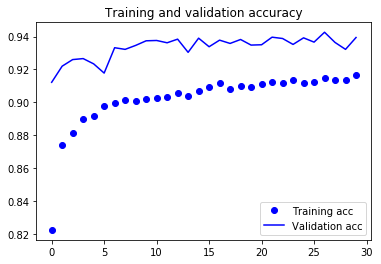

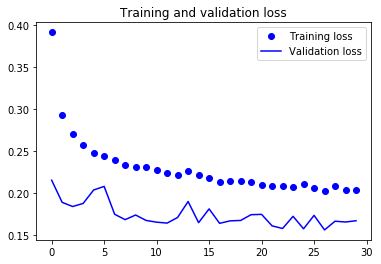

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [42]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [43]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [44]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=400,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=100)

Epoch 1/100
400/400 [==============================] - 201s 503ms/step - loss: 0.1970 - acc: 0.9177 - val_loss: 0.1302 - val_acc: 0.9544
Epoch 2/100
400/400 [==============================] - 193s 483ms/step - loss: 0.1544 - acc: 0.9372 - val_loss: 0.1136 - val_acc: 0.9600
Epoch 3/100
400/400 [==============================] - 193s 483ms/step - loss: 0.1351 - acc: 0.9457 - val_loss: 0.1078 - val_acc: 0.9650
Epoch 4/100
400/400 [==============================] - 193s 483ms/step - loss: 0.1193 - acc: 0.9524 - val_loss: 0.1050 - val_acc: 0.9650
Epoch 5/100
400/400 [==============================] - 194s 484ms/step - loss: 0.1121 - acc: 0.9557 - val_loss: 0.1140 - val_acc: 0.9666
Epoch 6/100
400/400 [==============================] - 193s 483ms/step - loss: 0.1028 - acc: 0.9603 - val_loss: 0.1055 - val_acc: 0.9674
Epoch 7/100
400/400 [==============================] - 193s 483ms/step - loss: 0.0973 - acc: 0.9603 - val_loss: 0.1106 - val_acc: 0.9686
Epoch 8/100
400/400 [====================

In [45]:
model.save('VGG16_finetuning.h5')

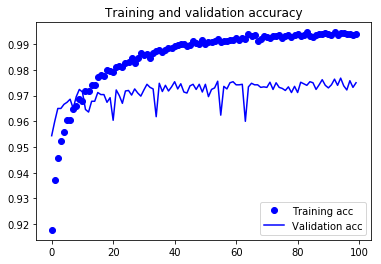

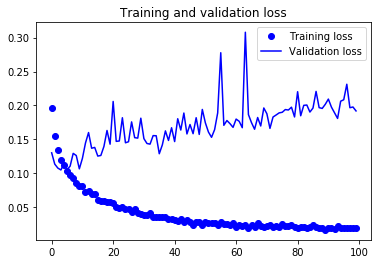

In [46]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

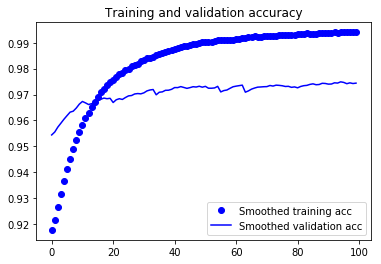

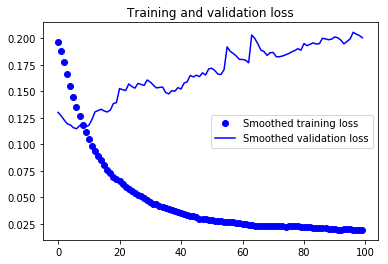

In [47]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()